## 📌 Title:
Credit Card Behaviour Score Prediction Using Classification and Risk-Based Techniques

---

## 🎯 Project Obejctive

The objective of this project is to develop a forward-looking, interpretable Behaviour Score model for Bank A that predicts the likelihood of a credit card customer defaulting on their payment in the following month. By leveraging historical behavioral data from over 30,000 customers, the project aims to:

- Build an accurate and robust classification model to identify potential defaulters in advance.

- Enhance the bank’s credit risk management by enabling proactive decision-making.

- Provide financial interpretability to understand the drivers of default behavior.

- Support early warning systems and risk-based customer strategies to reduce overall credit exposure and financial loss.

---

## 🎯 EDA Obejctive

- Explore the distribution and interrelationships of customer features in relation to default behavior.

- Uncover key behavioral patterns and early risk indicators that can inform predictive modeling.

- Generate actionable insights to improve credit risk management, support early intervention strategies, and guide risk-based decision-making.

- Lay the groundwork for a model that not only predicts defaults but also provides financial interpretability, helping the bank understand and proactively manage credit exposure.
---
## 📊 Dataset Description

The dataset contains information on various demographic and financial attributes of credit card holders, including their past payment behavior. Each row represents a unique customer, and the columns are as follows:

| Column Name        | Description                                                                 |
|--------------------|-----------------------------------------------------------------------------|
| `Customer_Id`      | Unique identifier for each customer                                         |
| `marriage`         | Marital status (1 = Single, 2 = Married, 3 = Others)                        |
| `sex`              | Gender (1 = Male, 0 = Female)                                               |
| `education`        | Education level (1 = Graduate, 2 = University, 3 = High School, 4 = Others) |
| `LIMIT_BAL`        | Credit limit assigned to the customer                                       |
| `Age`              | Age in years                                                                |
| `PAY_0` to `PAY_6` | Payment status for each of the past 6 months                                |
| `BILL_AMT1` to `BILL_AMT6` | Total bill amount at the end of each month                    |
| `PAY_AMT1` to `PAY_AMT6`   | Payment made in each month toward previous month's bill         |
| `AVG_Bill_amt`     | Average bill amount over 6 months                                           |
| `PAY_TO_BILL_ratio`| Ratio of total payment to total bill over 6 months                         |
| `next_month_default` | Target variable: 1 if defaulted, 0 otherwise                            |

With this understanding, we now proceed to explore each feature in detail.

In [2]:
%pip install -q lightgbm xgboost imbalanced-learn shap joblib

import os, zipfile, joblib, warnings, gc, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from pathlib import Path
from lightgbm import LGBMClassifier
from datetime import datetime
import lightgbm as lgb
import xgboost as xgb


import shap
import joblib

Note: you may need to restart the kernel to use updated packages.


In [3]:
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score,make_scorer,precision_score,precision_recall_curve,

    f1_score,recall_score, confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE


In [4]:
%pip install shap

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [5]:
warnings.filterwarnings("ignore", category=UserWarning)

RANDOM_STATE = 42

In [6]:
zip_path = r"C:\Users\abhis\Downloads\Datasets_final.zip"
extract_to = r"C:\Users\abhis\Downloads\Datasets_final"

# Extract ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction complete.")


Extraction complete.


In [7]:
# List all files to check their names
for root, dirs, files in os.walk(extract_to):
    for file in files:
        print(os.path.join(root, file))


C:\Users\abhis\Downloads\Datasets_final\train_dataset_final1.csv
C:\Users\abhis\Downloads\Datasets_final\validate_dataset_final.csv


In [8]:
train_csv_path = os.path.join(extract_to, 'train_dataset_final1.csv')
val_csv_path = os.path.join(extract_to, 'validate_dataset_final.csv')

# Load datasets
train = pd.read_csv(train_csv_path)
val = pd.read_csv(val_csv_path)

# Check data
print(train.head())
print(val.head())


   Customer_ID  marriage  sex  education  LIMIT_BAL   age  pay_0  pay_2  \
0         5017         2    0          2      60000  25.0      2      2   
1         5018         2    1          1     290000  24.0      0      0   
2         5019         1    0          2     180000  63.0      0      0   
3         5020         1    1          2     210000  43.0      0      0   
4         5021         2    0          1     280000  32.0     -2     -2   

   pay_3  pay_4  ...  Bill_amt6  pay_amt1  pay_amt2  pay_amt3  pay_amt4  \
0      2      0  ...   20750.63   2000.21      0.00   1134.85   1821.78   
1     -2     -2  ...    1350.30      0.00      0.17      0.00   2700.10   
2      0      0  ...   52991.51   2086.94   2199.99   1845.66   2000.35   
3      0      0  ...   76945.47   3348.07   3380.91   3400.45   2683.97   
4     -2     -2  ...       1.35    999.78   3186.27  45027.78   2100.09   

   pay_amt5  pay_amt6  AVG_Bill_amt  PAY_TO_BILL_ratio  next_month_default  
0   1500.03   1500.24

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25247 entries, 0 to 25246
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer_ID         25247 non-null  int64  
 1   marriage            25247 non-null  int64  
 2   sex                 25247 non-null  int64  
 3   education           25247 non-null  int64  
 4   LIMIT_BAL           25247 non-null  int64  
 5   age                 25121 non-null  float64
 6   pay_0               25247 non-null  int64  
 7   pay_2               25247 non-null  int64  
 8   pay_3               25247 non-null  int64  
 9   pay_4               25247 non-null  int64  
 10  pay_5               25247 non-null  int64  
 11  pay_6               25247 non-null  int64  
 12  Bill_amt1           25247 non-null  float64
 13  Bill_amt2           25247 non-null  float64
 14  Bill_amt3           25247 non-null  float64
 15  Bill_amt4           25247 non-null  float64
 16  Bill

In [10]:
train.describe()

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
count,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000,25121.000000,25247.000000,25247.000000,25247.000000,25247.000000,...,25247.000000,25247.000000,2.524700e+04,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000
mean,17640.000000,1.551907,0.604111,1.852101,168342.060443,35.438199,-0.042857,-0.159544,-0.190359,-0.241415,...,38806.221029,5718.624966,6.047352e+03,5288.910651,4865.960834,4906.766828,5270.499287,44859.647485,0.362962,0.190399
std,7288.325459,0.522629,0.489050,0.797379,129892.784807,9.174998,1.099315,1.173990,1.172636,1.146753,...,59182.792531,16806.842125,2.400962e+04,17851.879609,15979.116544,15860.726852,17960.816915,62819.226119,5.047206,0.392624
min,5017.000000,0.000000,0.000000,0.000000,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-56043.170000,-546.930000,0.000000
25%,11328.500000,1.000000,0.000000,1.000000,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,1241.710000,999.985000,9.219100e+02,399.990000,300.150000,262.365000,130.070000,4858.670000,0.040000,0.000000
50%,17640.000000,2.000000,1.000000,2.000000,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,17102.580000,2145.020000,2.026830e+03,1844.300000,1500.100000,1513.790000,1500.040000,21102.830000,0.090000,0.000000
75%,23951.500000,2.000000,1.000000,2.000000,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,49245.195000,5031.150000,5.000190e+03,4600.640000,4014.990000,4099.890000,4018.780000,57136.580000,0.590000,0.000000
max,30263.000000,3.000000,1.000000,6.000000,1000000.000000,79.000000,8.000000,8.000000,8.000000,7.000000,...,961663.620000,873551.980000,1.684259e+06,896040.150000,621000.080000,426529.180000,528666.150000,877313.830000,205.380000,1.000000


In [11]:
print(val.columns.tolist())


['Customer_ID', 'marriage', 'sex', 'education', 'LIMIT_BAL', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio']


In [12]:
print("Train shape:", train.shape, "Validation shape:", val.shape)

Train shape: (25247, 27) Validation shape: (5016, 26)


In [13]:
print(train['next_month_default'].value_counts())

next_month_default
0    20440
1     4807
Name: count, dtype: int64


In [14]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = train[train['next_month_default'] == 0]
df_minority = train[train['next_month_default'] == 1]

# Undersample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,
                                 n_samples=len(df_minority),
                                 random_state=42)

# Combine minority class with downsampled majority class
train = pd.concat([df_majority_downsampled, df_minority])

In [15]:
print(train['next_month_default'].value_counts())

next_month_default
0    4807
1    4807
Name: count, dtype: int64


In [16]:
# Minimal NA handling
train["age"] = train["age"].fillna(train["age"].median())
val["age"] = val["age"].fillna(train["age"].median()
                              )

# Category maps (kept as int for model – readable map only for EDA)
cat_maps = {
    "sex":      {1: "Male", 0: "Female"},
    "marriage": {1: "Married", 2: "Single", 3: "Others"},
    "education":{1: "Graduate", 2: "University", 3: "HighSchool", 4: "Others"}
}


In [17]:
train.isnull().sum()

Customer_ID           0
marriage              0
sex                   0
education             0
LIMIT_BAL             0
age                   0
pay_0                 0
pay_2                 0
pay_3                 0
pay_4                 0
pay_5                 0
pay_6                 0
Bill_amt1             0
Bill_amt2             0
Bill_amt3             0
Bill_amt4             0
Bill_amt5             0
Bill_amt6             0
pay_amt1              0
pay_amt2              0
pay_amt3              0
pay_amt4              0
pay_amt5              0
pay_amt6              0
AVG_Bill_amt          0
PAY_TO_BILL_ratio     0
next_month_default    0
dtype: int64

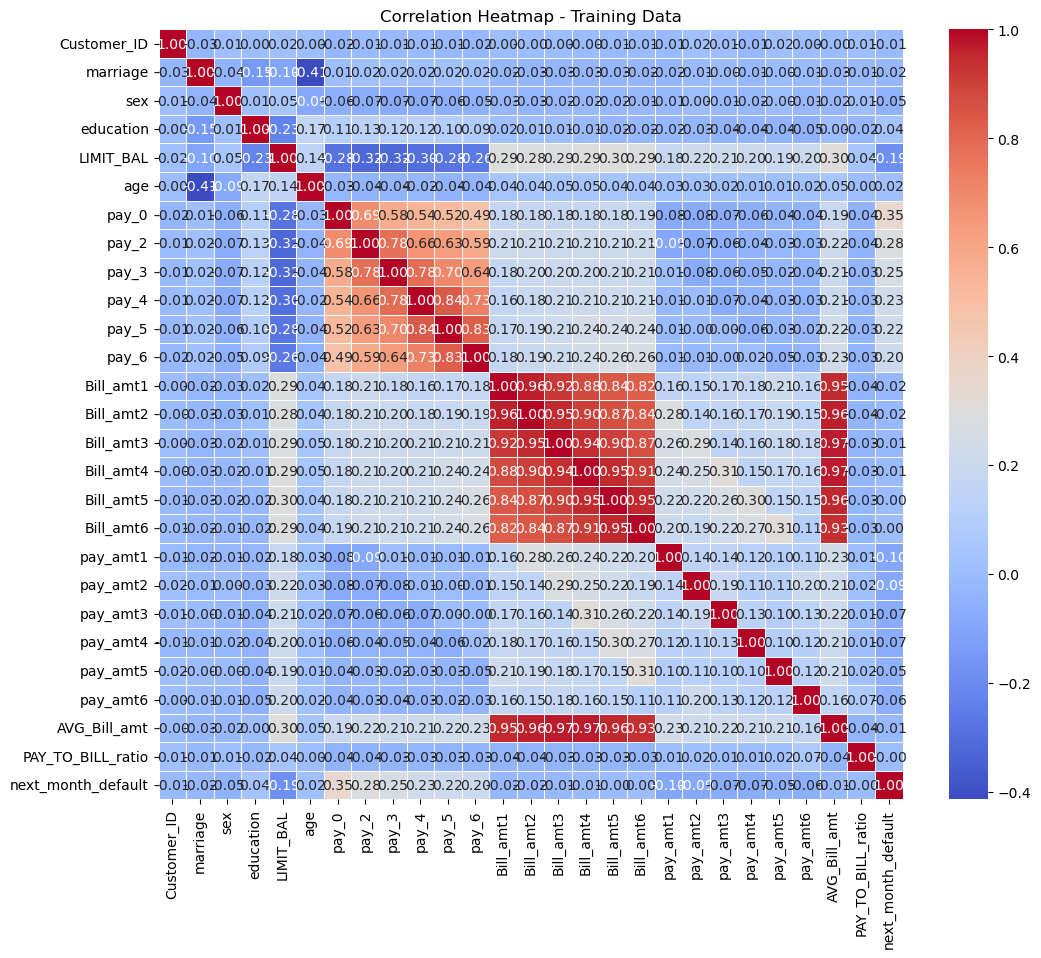

In [18]:
correlation_matrix = train.corr()

# 3. Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap - Training Data")
plt.show()

In [19]:
print(train.columns)

Index(['Customer_ID', 'marriage', 'sex', 'education', 'LIMIT_BAL', 'age',
       'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'Bill_amt1',
       'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6',
       'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'AVG_Bill_amt', 'PAY_TO_BILL_ratio', 'next_month_default'],
      dtype='object')


In [20]:
for df in [train, val]:
    df['AVG_Pay_amt'] = df[['pay_amt1','pay_amt2','pay_amt3','pay_amt4','pay_amt5','pay_amt6']].mean(axis=1)
    df['PAY_TO_BILL_ratio'] = df['AVG_Pay_amt'] / df['AVG_Bill_amt']
    df['PAY_TO_BILL_ratio'] = df['PAY_TO_BILL_ratio'].replace([np.inf, -np.inf], 0).fillna(0)

    df.drop(columns=[
        'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6',
        'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6'
    ], inplace=True, errors='ignore')


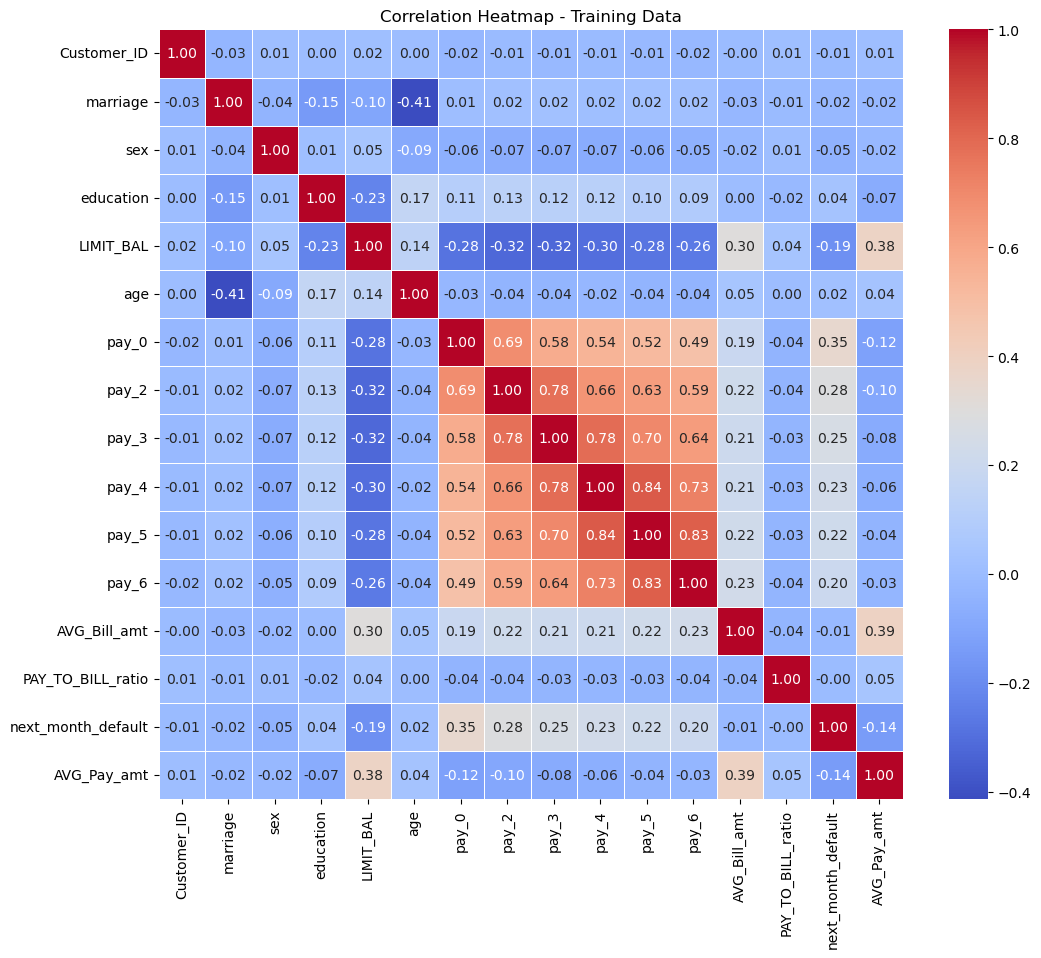

In [21]:
correlation_matrix = train.corr()

# 3. Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap - Training Data")
plt.show()

In [22]:
print(train.columns)

Index(['Customer_ID', 'marriage', 'sex', 'education', 'LIMIT_BAL', 'age',
       'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'AVG_Bill_amt',
       'PAY_TO_BILL_ratio', 'next_month_default', 'AVG_Pay_amt'],
      dtype='object')


In [23]:
print(val.columns)

Index(['Customer_ID', 'marriage', 'sex', 'education', 'LIMIT_BAL', 'age',
       'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'AVG_Bill_amt',
       'PAY_TO_BILL_ratio', 'AVG_Pay_amt'],
      dtype='object')


In [24]:
numerical_cols = [
    'LIMIT_BAL', 'age',
    'pay_0', 'pay_2', 'pay_3', 'pay_3', 'pay_5', 'pay_6',
    'AVG_Bill_amt', 'PAY_TO_BILL_ratio'
]


<Axes: title={'center': 'Target Distribution After Outlier Removal'}, xlabel='next_month_default'>

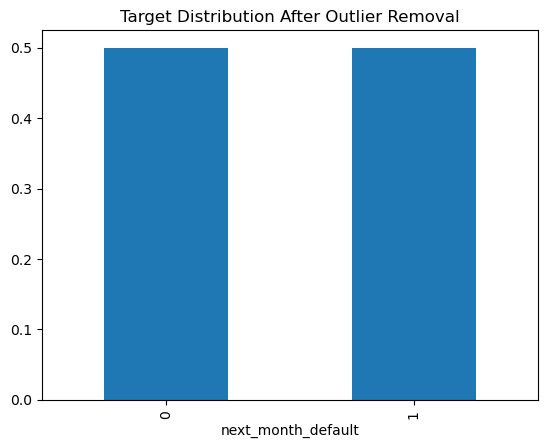

In [25]:
train['next_month_default'].value_counts(normalize=True).plot(kind='bar', title='Target Distribution After Outlier Removal')

## EDA of categorical cells

## 1.on the basis of sex

<Axes: >

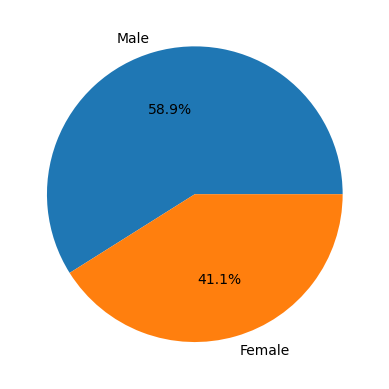

In [26]:
train['sex'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['Male', 'Female'], ylabel='')

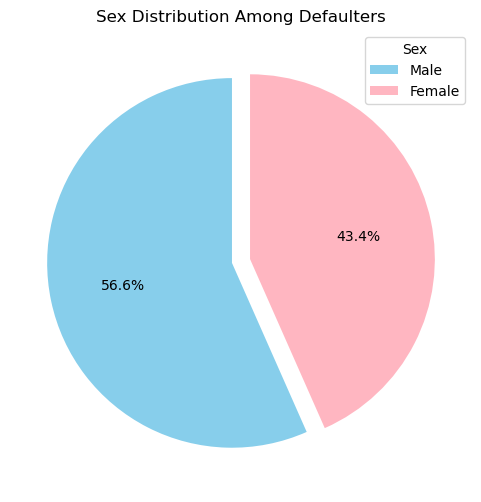

In [26]:
defaulters = train[train['next_month_default'] == 1]
sex_counts = defaulters['sex'].value_counts()
labels = ['Male' if x == 1 else 'Female' for x in sex_counts.index]
colors = ['skyblue', 'lightpink']

plt.figure(figsize=(6,6))
wedges, _, _ = plt.pie(sex_counts, autopct='%1.1f%%', startangle=90, labels=None, colors=colors, explode=[0.05]*len(sex_counts))
plt.legend(wedges, labels, title='Sex', loc='upper right', bbox_to_anchor=(1, 1))
plt.title('Sex Distribution Among Defaulters')
plt.show()

### Insight: Gender and Default Behavior

- **Female customers have a higher default rate** compared to male customers.
- However, **male customers make up a larger share of total defaulters** due to their higher representation in the overall customer base.
- The **proportion of males among defaulters** is only slightly lower than their overall proportion in the dataset, indicating that gender alone may not be a strong predictor.
- The **mean credit limit (`LIMIT_BAL`) among male and female defaulters is nearly the same**, suggesting credit limit is not significantly skewed by gender within defaulters.

---

 2. on the basis of age

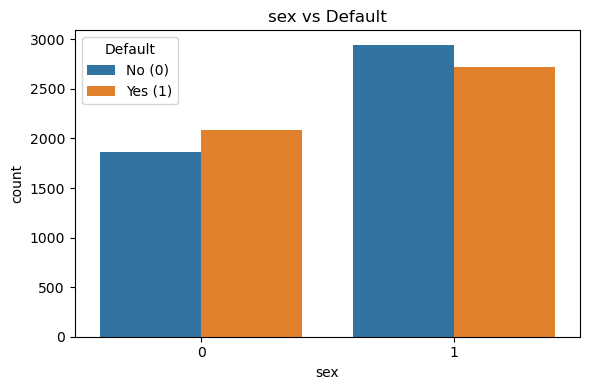

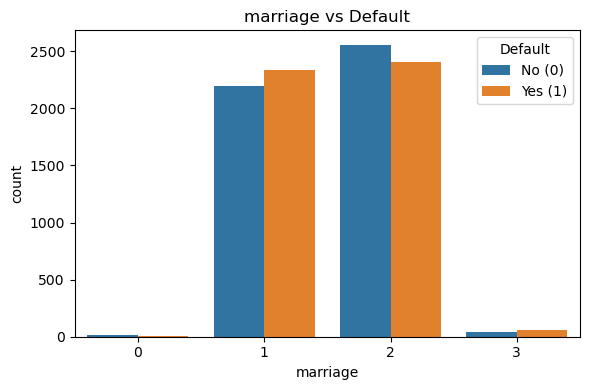

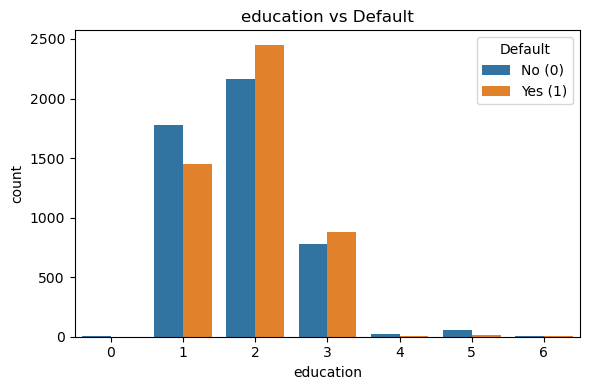

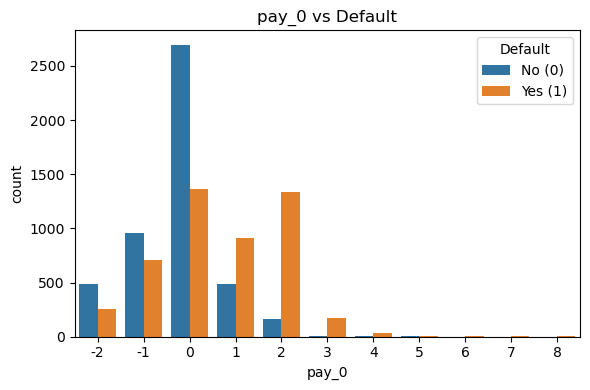

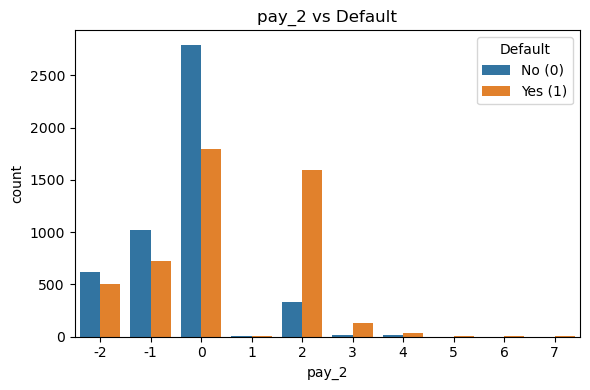

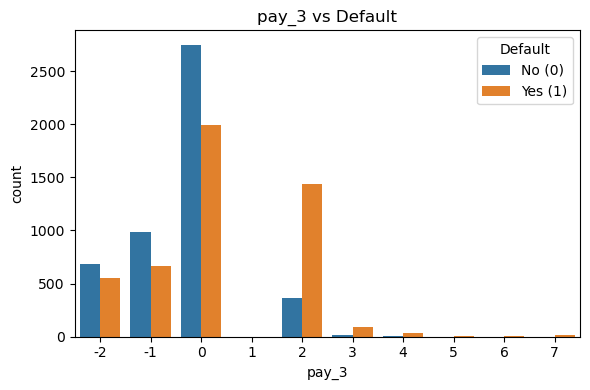

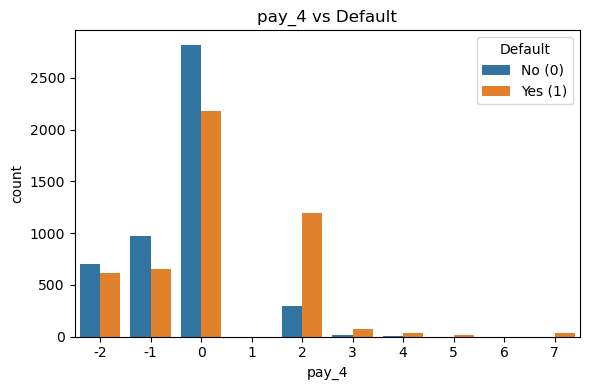

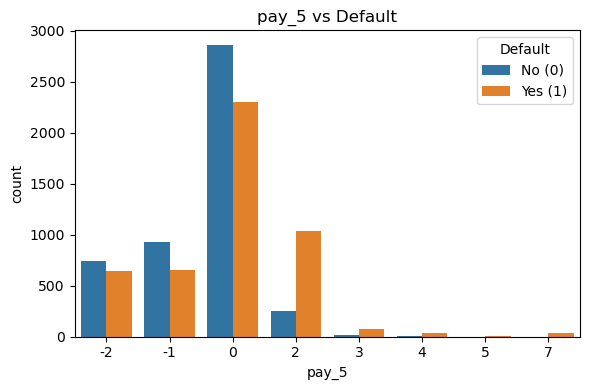

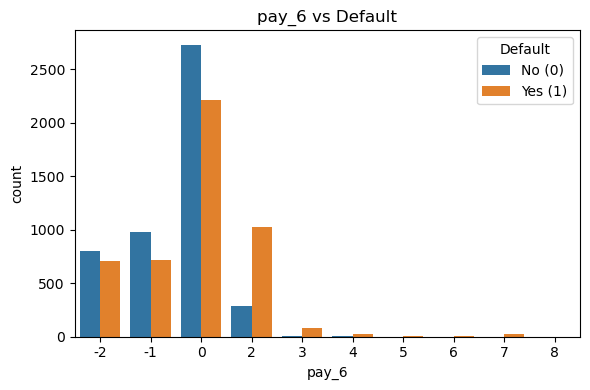

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

categorical_vars = ['sex', 'marriage', 'education', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

for col in categorical_vars:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=train, x=col, hue='next_month_default')
    plt.title(f"{col} vs Default")
    plt.legend(title='Default', labels=['No (0)', 'Yes (1)'])
    plt.tight_layout()
    plt.show()


# Exploratory Data Analysis (EDA) Summary

## Default Analysis by Features

### 1. `pay_0` vs Default  
- **Distribution**:  
  - Most non-defaulters (`0`) have `pay_0` values clustered around `-2` to `0`.  
  - Defaulters (`1`) show higher frequencies for `pay_0` values `≥ 1`.  
- **Insight**: Late payments (`pay_0 ≥ 1`) correlate with higher default rates.  

---

### 2. `pay_6` vs Default  
- **Trend**: Similar to `pay_0`, but with fewer extreme values (`6–8`).  
- **Key Observation**: Consistent pattern of defaults increasing with positive `pay_*` values.  

---

### 3. `sex` vs Default  
- **Counts**:  
  - Non-defaulters (`0`): Dominant group (e.g., 12,000 counts).  
  - Defaulters (`1`): Significantly fewer (e.g., 2,000 counts).  
 

---

### 4. `marriage` vs Default  
- **Categories**: Likely encoded as `0, 1, 2, 3` (e.g., single, married, etc.).  
-  

---

### 5. `education` vs Default  
- **Distribution**:  
  - Education levels (`0–6`) show varying default rates.  
  - Highest counts in lower education levels (e.g., `0` or `1`).  
- **Insight**: Lower education may correlate with higher default risk.  

---

### 6. `pay_2` vs Default  
- **Pattern**: Mirrors `pay_0` and `pay_6` trends.  
- **Takeaway**: Repeated late payments (`pay_2 ≥ 1`) are strong default predictors.  

---


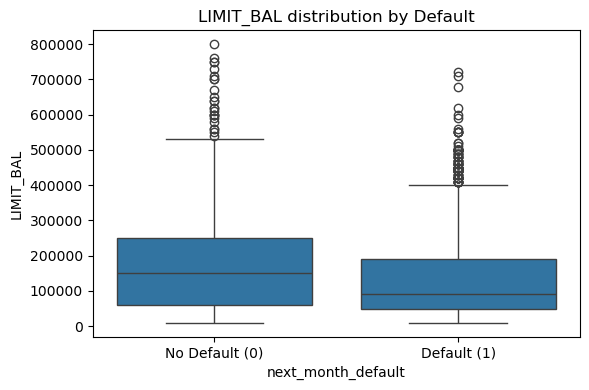

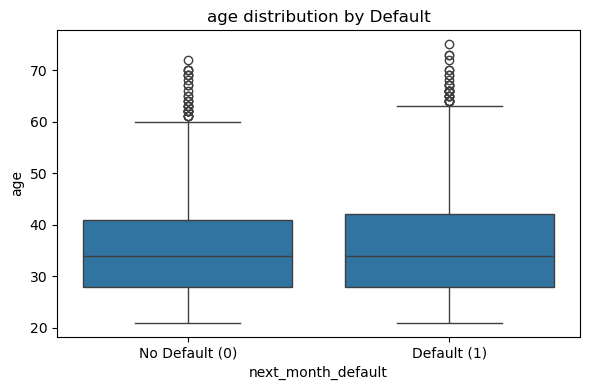

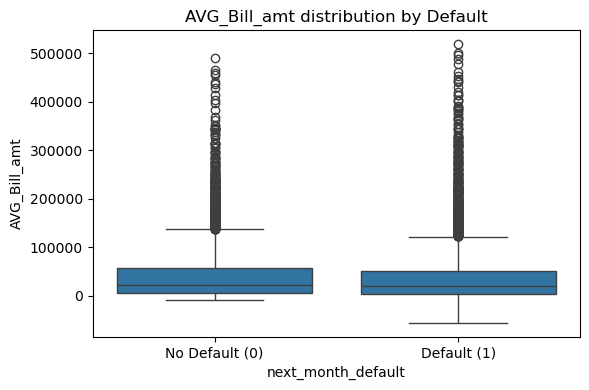

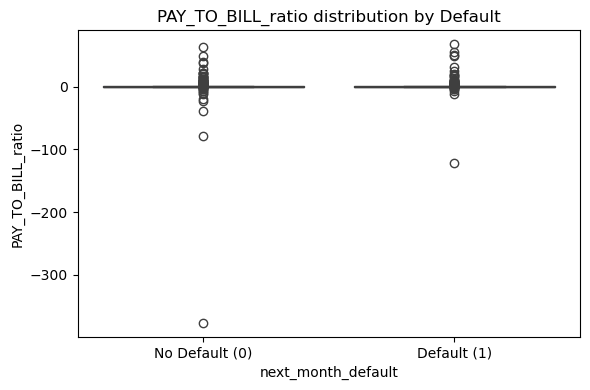

In [28]:
numerical_vars = ['LIMIT_BAL', 'age', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio']

for col in numerical_vars:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=train, x='next_month_default', y=col)
    plt.title(f"{col} distribution by Default")
    plt.xticks([0, 1], ['No Default (0)', 'Default (1)'])
    plt.tight_layout()
    plt.show()


2. on the basis of age

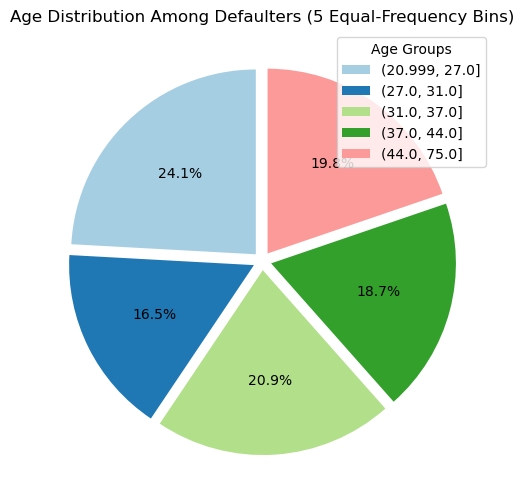

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Create quantile-based age bins on the training set
train['age_bin'] = pd.qcut(train['age'], q=5, duplicates='drop')  # handles ties if bins overlap

# Filter defaulters from training data
defaulters = train[train['next_month_default'] == 1]

# Count defaulters in each age bin
age_counts = defaulters['age_bin'].value_counts().sort_index()

# Define pie chart colors
colors = plt.cm.Paired.colors[:len(age_counts)]

# Plot pie chart
plt.figure(figsize=(6, 6))
wedges, _, _ = plt.pie(
    age_counts,
    autopct='%1.1f%%',
    startangle=90,
    labels=None,
    colors=colors,
    explode=[0.05] * len(age_counts)
)

# Add legend and title
plt.legend(wedges, age_counts.index.astype(str), title='Age Groups', loc='upper right', bbox_to_anchor=(1, 1))
plt.title('Age Distribution Among Defaulters (5 Equal-Frequency Bins)')
plt.show()


### taking age and sex at same time

C:\Users\abhis\AppData\Local\Temp\ipykernel_29248\1439615828.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train.groupby(['age_bin', 'sex'])['next_month_default']


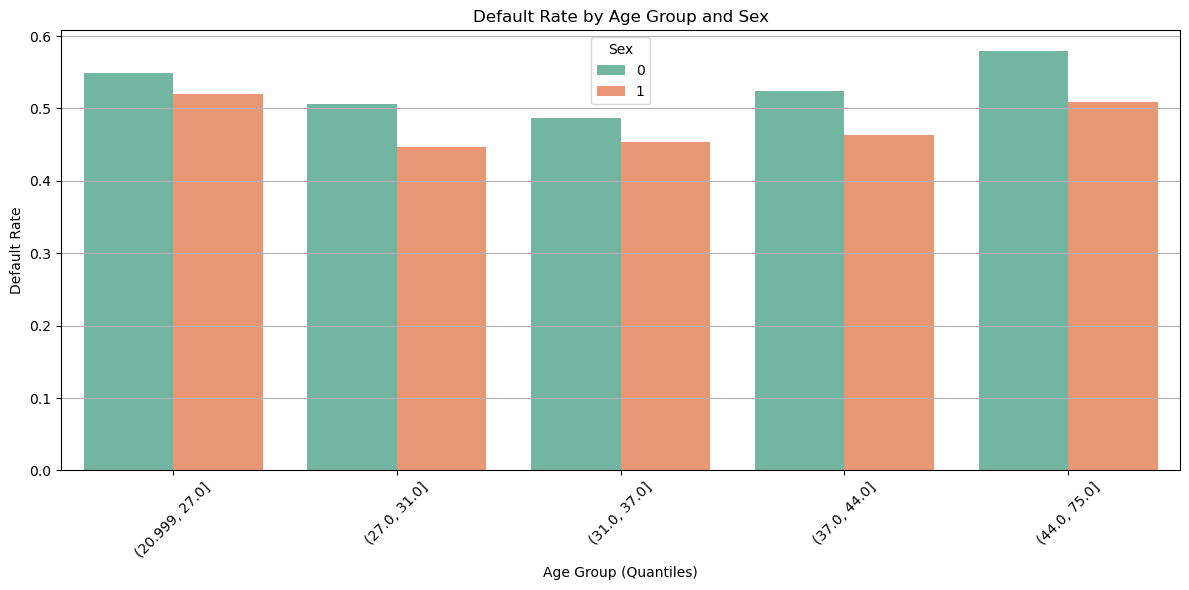

In [36]:

train['age_bin'] = pd.qcut(train['age'], q=5, duplicates='drop')

# Step 2: Group by age bin and sex, calculate default rate
grouped = (
    train.groupby(['age_bin', 'sex'])['next_month_default']
    .mean()
    .reset_index(name='default_rate')
)
grouped['age_bin'] = grouped['age_bin'].astype(str)  # convert bins to string for x-axis

# Step 3: Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=grouped,
    x='age_bin',
    y='default_rate',
    hue='sex',
    palette='Set2'
)

plt.xlabel('Age Group (Quantiles)')
plt.ylabel('Default Rate')
plt.title('Default Rate by Age Group and Sex')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Sex')
plt.tight_layout()
plt.show()

### Insight: Marital Status, Age, Gender, and Default Behavior

- **Married individuals have a higher default rate** overall.
- Among defaulters, **single individuals make up the largest proportion**, likely due to their higher population share.
- **Female default rates are higher than male default rates across all marital statuses**.
- Within **marital status = 3 (Others)**, **females show the highest default rate**, but this group has a very small population, so generalizing from it isn't reliable.
- Among males, **married men** have the highest default counts.
- Among females, **single women** are the largest group of defaulters.

#### Age-Marriage-Gender Interaction:

- In the **43–79 age group with marital status = married**, the number of male and female defaulters is nearly equal.
- In the **27–31 age group with marital status = single**, defaulters are balanced between genders.
- For **marital status = other**, defaulters are evenly distributed across all age groups.
- The **21–27 age group** shows a significant gender gap: married and single **female defaulters outnumber males**, and they also have the **highest default rate** when ignoring the outlier group (marital status = 3).

#### Limit Balance Insight:

- **Defaulters generally have a lower mean `LIMIT_BAL` than non-defaulters**.
- However, the **mean `LIMIT_BAL` among defaulters is fairly consistent across categories**, though influenced by outliers.

> 📌 Conclusion: While marital status and age reveal several default risk patterns, the **most at-risk group appears to be married females aged 21–27**, excluding small-population anomalies.

---

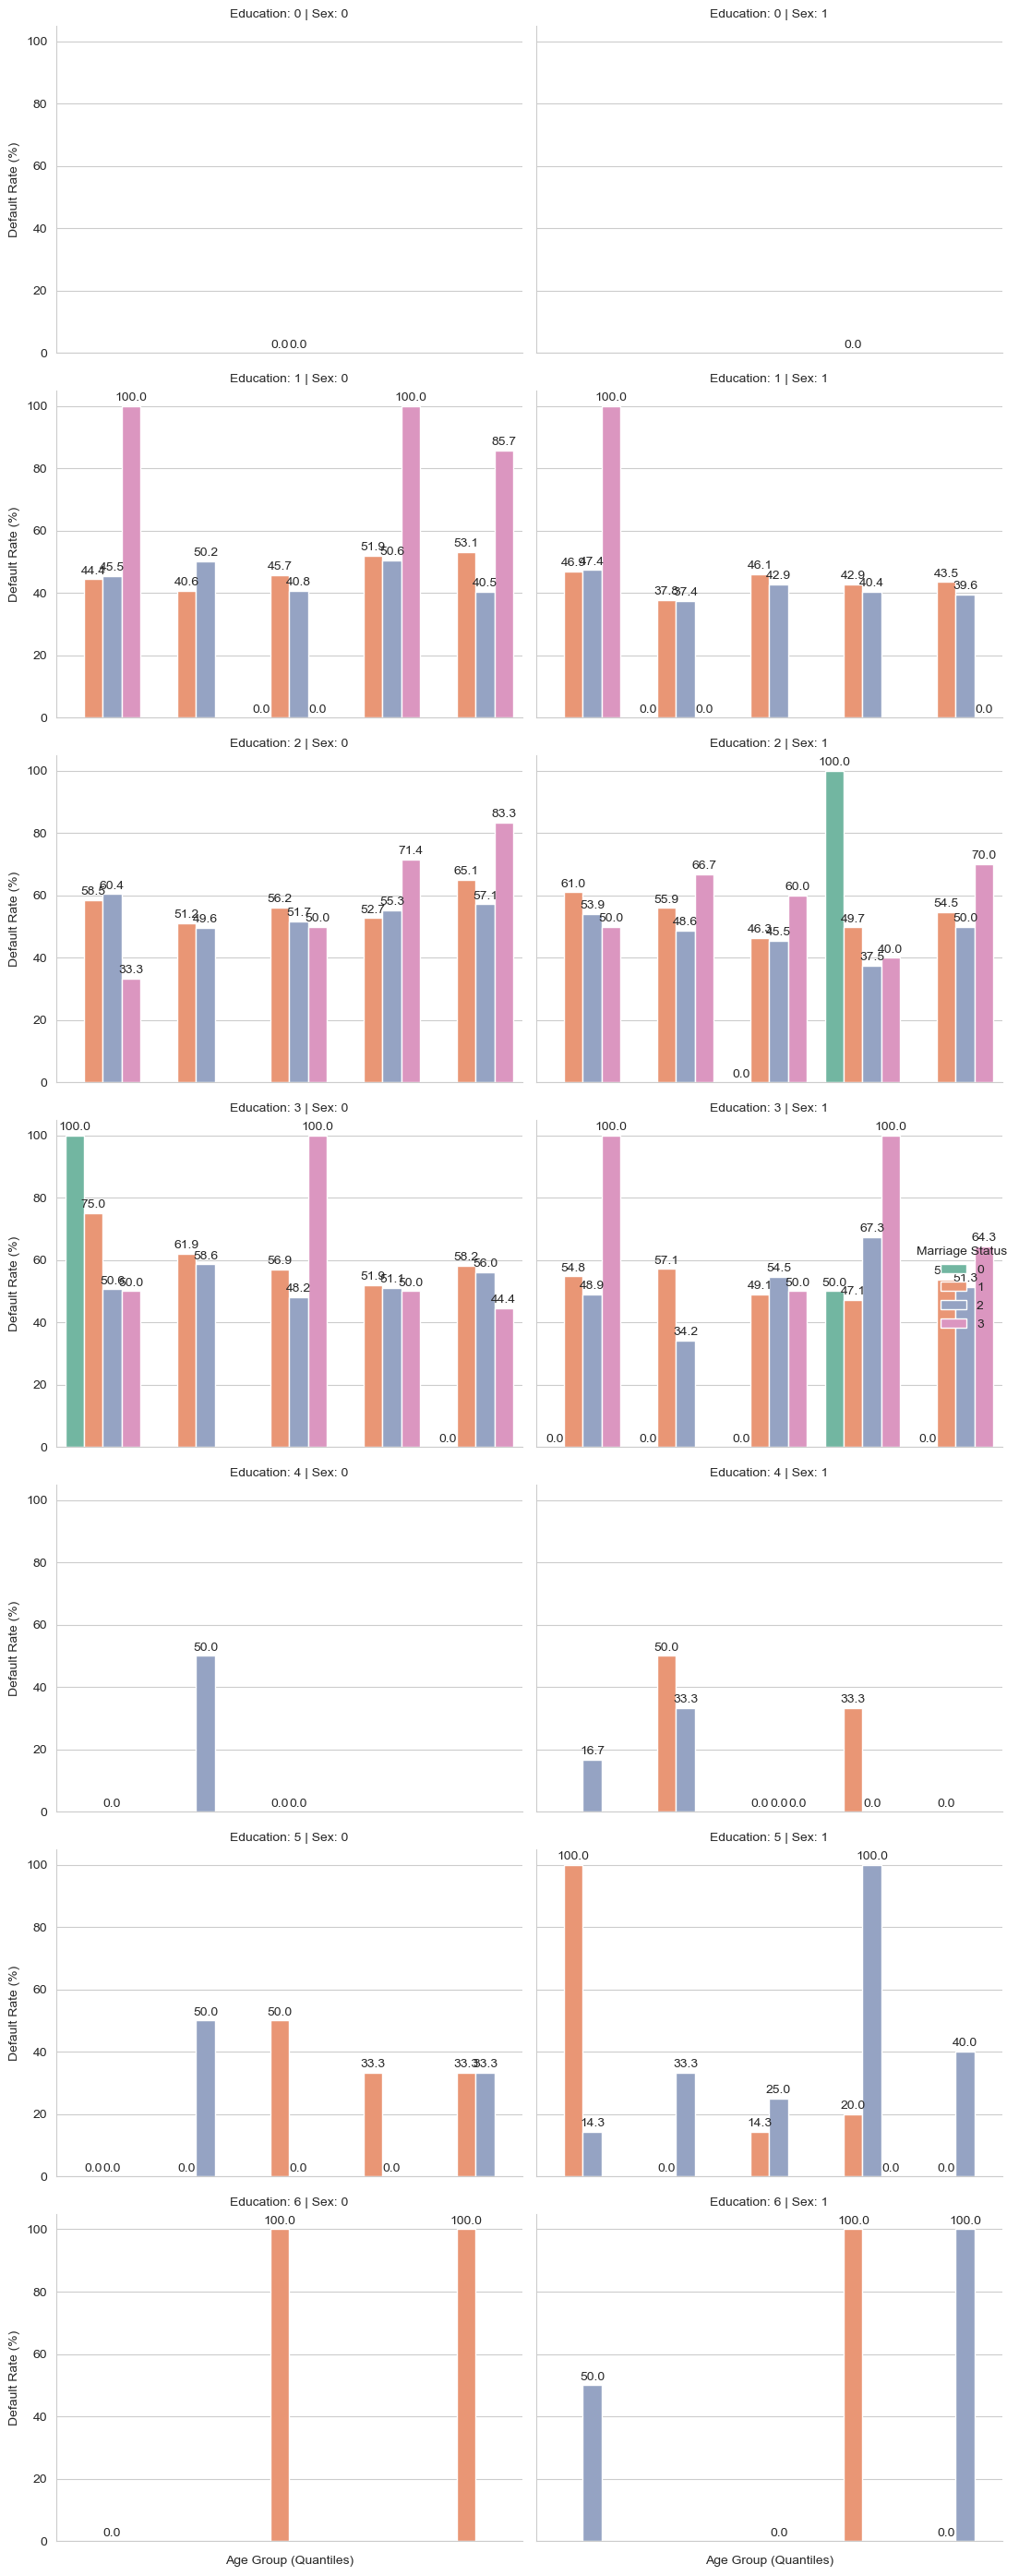

In [39]:

# Step 1: Create age bins
train['age_bin'] = pd.qcut(train['age'], q=5, duplicates='drop')
train['age_bin_str'] = train['age_bin'].astype(str)

# Step 2: Group by necessary categories and calculate default rate
grouped = train.groupby(['age_bin_str', 'sex', 'education', 'marriage']).agg(
    default_rate=('next_month_default', lambda x: 100 * x.mean())
).reset_index()

# Step 3: Plot
sns.set_style("whitegrid")

g = sns.catplot(
    data=grouped,
    kind='bar',
    x='age_bin_str',
    y='default_rate',
    hue='marriage',
    col='sex',
    row='education',
    palette='Set2',
    height=4,
    aspect=1.3,
    legend_out=True
)

g.set_titles(row_template='Education: {row_name}', col_template='Sex: {col_name}')
g.set_axis_labels('Age Group (Quantiles)', 'Default Rate (%)')

# Rotate x-axis labels and add bar labels
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f', label_type='edge', padding=2)

# Fix the legend placement and title
g._legend.set_title('Marriage Status')

plt.tight_layout()
plt.show()


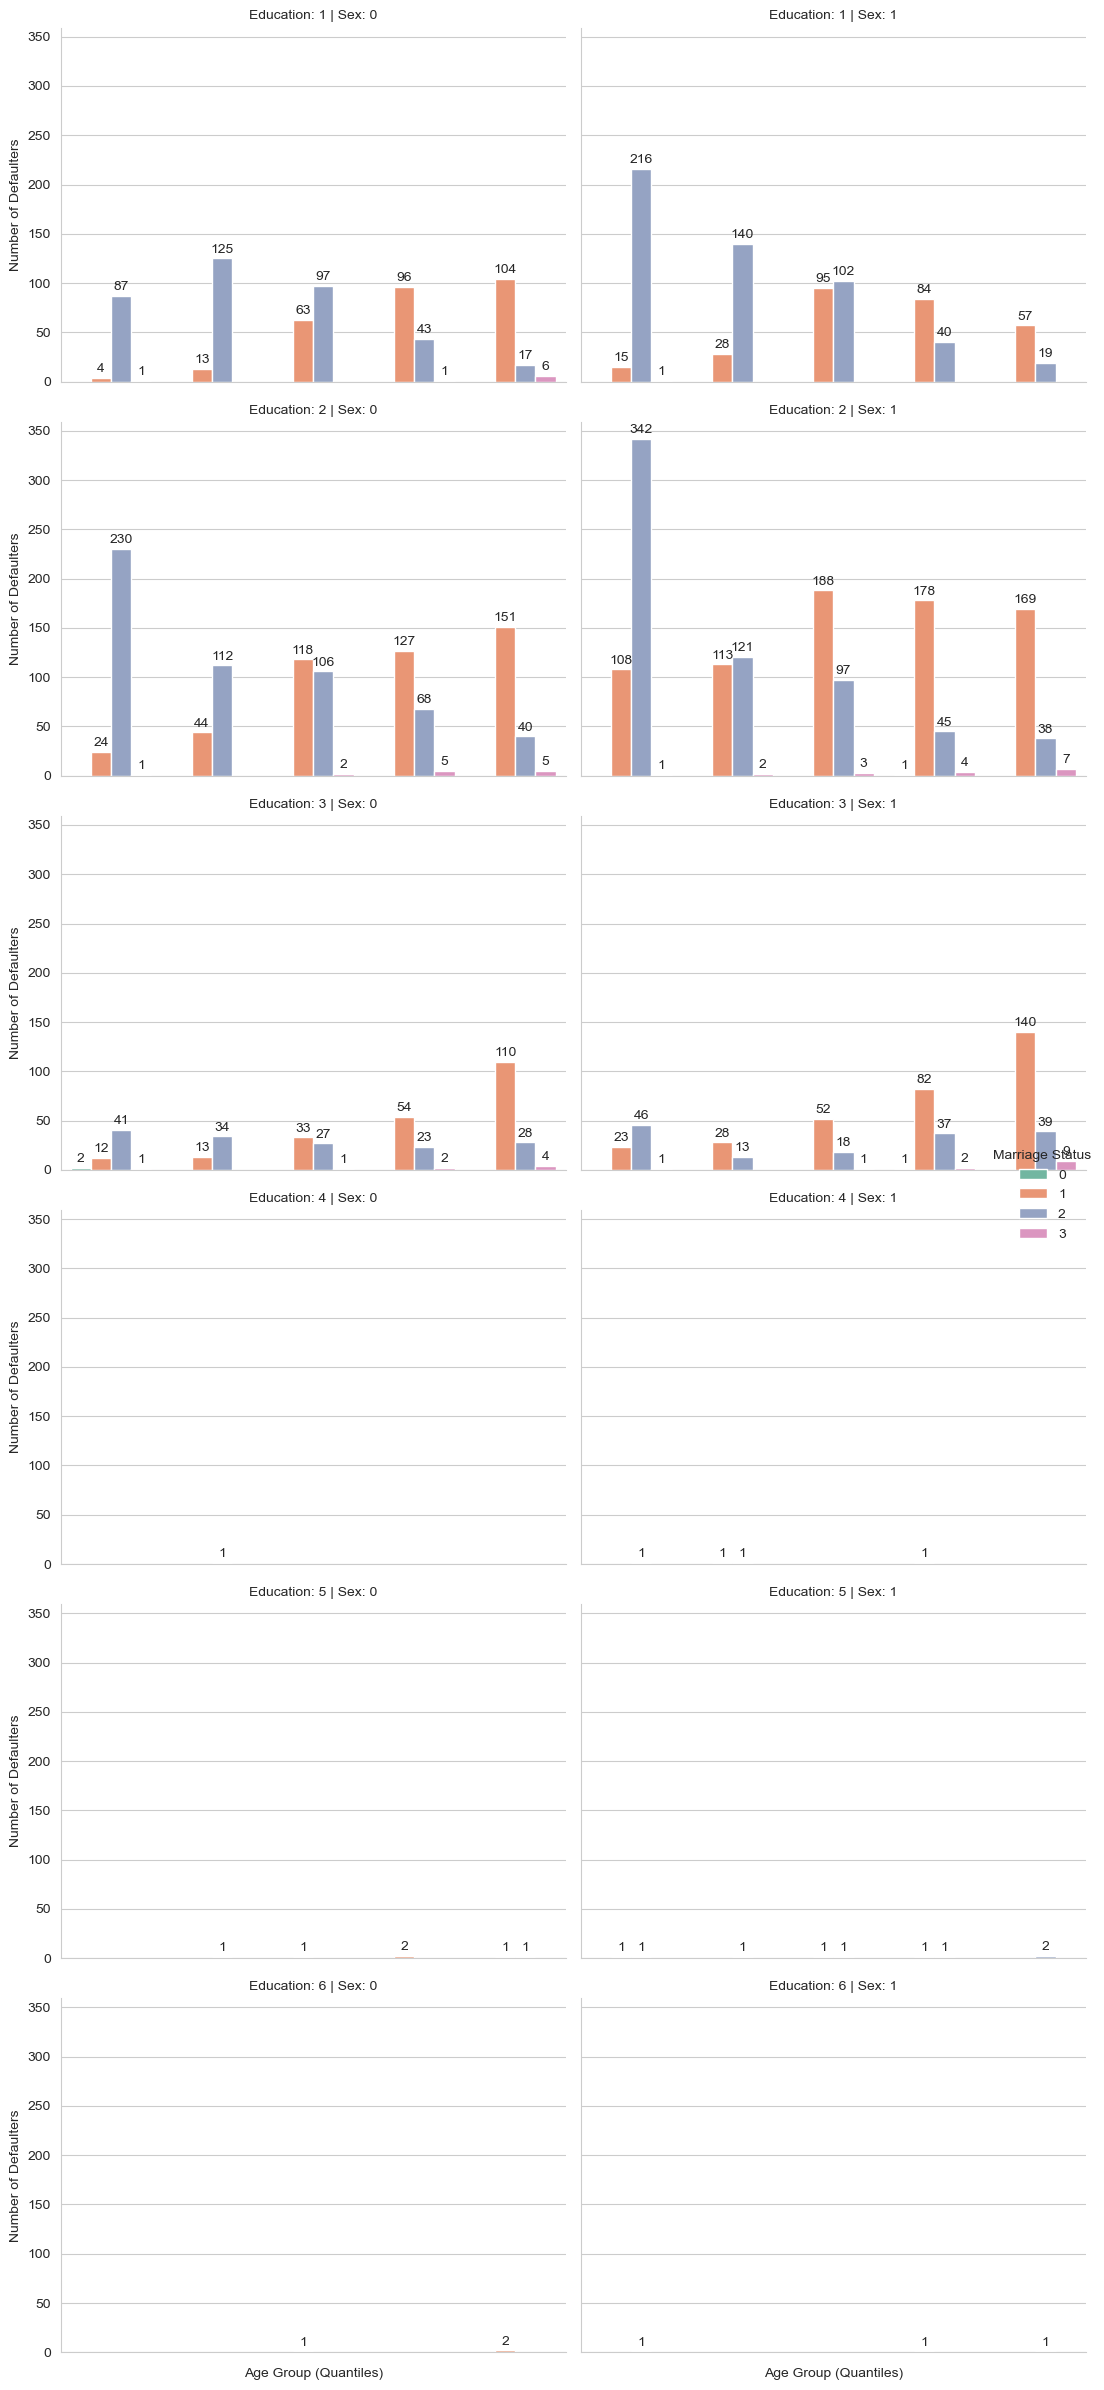

In [40]:
train['age_bin'] = pd.qcut(train['age'], q=5, duplicates='drop')
train['age_bin_str'] = train['age_bin'].astype(str)

# Filter defaulters and group by multiple features
grouped_counts = train[train['next_month_default'] == 1].groupby(
    ['age_bin', 'sex', 'education', 'marriage'], observed=True
).size().reset_index(name='defaulter_count')

# Convert age bin to string for plotting
grouped_counts['age_bin_str'] = grouped_counts['age_bin'].astype(str)

# Drop rows with missing values in important columns
grouped_counts.dropna(subset=['sex', 'marriage', 'education', 'defaulter_count'], inplace=True)

# Plotting
sns.set_style("whitegrid")

g = sns.catplot(
    data=grouped_counts,
    kind='bar',
    x='age_bin_str',
    y='defaulter_count',
    hue='marriage',
    col='sex',
    row='education',
    palette='Set2',
    height=4,
    aspect=1.3,
    legend_out=True
)

g.set_titles(row_template='Education: {row_name}', col_template='Sex: {col_name}')
g.set_axis_labels('Age Group (Quantiles)', 'Number of Defaulters')

# Add labels to each bar
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', padding=2)

# Adjust legend
g._legend.set_title('Marriage Status')

plt.tight_layout()
plt.show()


### Insight: Education, Age, Gender, and Default Behavior

#### Overall Education-Level Trends:
- **Highest default rate** is observed in the **High School** education group, followed closely by **University**.
- **University-educated customers make up the largest share of defaulters**, due to their high representation in the dataset.
- Across all education levels, the **female default rate is higher than male**, consistent with earlier findings.

#### Gender Distribution Across Education & Age:
- In most combinations of education and age groups, **male defaulters outnumber female defaulters**, except in three specific cases:
  1. **High School**, Age group: **27–31**
  2. **Graduate School**, Age group: **37–43**
  3. **Graduate School**, Age group: **43–79**

- The **female default rate is higher across almost all education-age combinations**, except in three:
  1. **Graduate School**, Age group: **21–27**
  2. **Education: Other**, Age group: **21–27**
  3. **Education: Other**, Age group: **37–43**

#### Highest Risk Subgroups:
- **Female defaulters with High School education, married, aged 21–27** show the **highest default rate** (excluding outliers from small-population categories).
- Among males, **those with High School education, aged 37–43, single** have the **highest default rate**.
- In terms of absolute numbers:
  - **Male, University-educated, aged 21–27, single** have the **highest number of defaulters**.
  - **Female, University-educated, aged 21–27, single** have the **highest number of defaulters among women**.

> 📌 These findings can help in designing targeted risk-based strategies based on education level, age, gender, and marital status combinations.


In [29]:
def feature_engineer(df):
    df = df.copy()

    # --- Utilisation ratio ---
    df["util_avg"] = df["AVG_Bill_amt"] / df["LIMIT_BAL"].replace(0, np.nan)

    # --- Delay-based features ---
    pay_cols = [f"pay_{i}" for i in [0, 2, 3, 4, 5, 6]]

    # Replace -2 with 0 (interpreted as "no delay"), clip negatives to 0
    pay_df = df[pay_cols].replace(-2, 0).clip(lower=0)

    df["max_delay"] = pay_df.max(axis=1)
    df["mean_delay"] = pay_df.mean(axis=1)
    df["num_overdue"] = (pay_df > 0).sum(axis=1)

    # Longest streak of overdue payments
    df["streak_overdue"] = pay_df.apply(
        lambda row: len(max("".join(row.gt(0).astype(int).astype(str)).split("0"), default="")), axis=1
    )

    # --- Payment behavior features ---
    df["pay_vs_bill_ratio"] = df["AVG_Pay_amt"] / df["AVG_Bill_amt"].replace(0, np.nan)
    df["pay_vs_limit_ratio"] = df["AVG_Pay_amt"] / df["LIMIT_BAL"].replace(0, np.nan)

    # --- Discretize age group (optional) ---
    df["age_bin"] = pd.cut(df["age"], bins=[20, 30, 40, 50, 60, 70, 100], labels=False)

    # --- Debt pressure feature ---
    df["debt_pressure"] = df["AVG_Bill_amt"] - df["AVG_Pay_amt"]

    return df


In [30]:
target = 'next_month_default'


In [31]:
train_fe = feature_engineer(train)
val_fe   = feature_engineer(val)




In [32]:
y = train_fe[target].values
X = train_fe.drop(columns=[target, 'Customer_ID'])  # Exclude ID from features


In [33]:
cat_candidates = ["sex", "education", "marriage", "age_bin"]
categorical_cols = [c for c in cat_candidates if c in X.columns]
numeric_cols = [c for c in X.columns if c not in categorical_cols]
from sklearn.decomposition import PCA


In [34]:
numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Optional: use if you want to include categorical features
categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine them
preprocess = ColumnTransformer([
    ("num", numeric_tf, numeric_cols),
    ("cat", categorical_tf, categorical_cols)
])


In [35]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.svm import SVC


In [36]:
models = {
    "logreg": (
        LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            random_state=RANDOM_STATE
        ),
        {
            "clf__C": [0.1, 1, 10]
        }
    ),

    "rf": (
        RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            class_weight="balanced",
            random_state=RANDOM_STATE
        ),
        {
            "clf__max_depth": [None, 10, 20],
            "clf__min_samples_leaf": [1, 5]
        }
    ),

    "xgb": (
        xgb.XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            use_label_encoder=False,
            random_state=RANDOM_STATE,
            n_estimators=400,
            scale_pos_weight=(y == 0).sum() / (y == 1).sum()
        ),
        {
            "clf__max_depth": [3, 5],
            "clf__learning_rate": [0.05, 0.1]
        }
    ),

    "lgb": (
        lgb.LGBMClassifier(
            n_estimators=500,
            objective="binary",
            class_weight="balanced",
            random_state=RANDOM_STATE
        ),
        {
            "clf__num_leaves": [31, 63],
            "clf__learning_rate": [0.05, 0.1]
        }
    ),

    "svm": (
        SVC(
            probability=True,
            class_weight="balanced",
            random_state=RANDOM_STATE
        ),
        {
            "clf__C": [0.1, 1],
            "clf__kernel": ["linear", "rbf"]
        }
    )
}


In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import warnings

warnings.filterwarnings("ignore")

# Custom F2 score
def f2_score_custom(y_true, y_pred):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    if precision + recall == 0:
        return 0.0
    return 5 * precision * recall / (4 * precision + recall)

# Scoring dictionary
scoring = {
    "roc_auc": "roc_auc",
    "f1": make_scorer(f1_score),
    "f2": make_scorer(f2_score_custom),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
}

# Cross-validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Models and hyperparameter grids
models = {
    "RandomForest": (
        RandomForestClassifier(random_state=42),
        {
            "clf__n_estimators": [100],
            "clf__max_depth": [5, 10]
        }
    ),
    "GradientBoosting": (
        GradientBoostingClassifier(random_state=42),
        {
            "clf__n_estimators": [100],
            "clf__learning_rate": [0.1, 0.5]
        }
    ),
    "LogisticRegression": (
        LogisticRegression(max_iter=1000, solver="liblinear", random_state=42),
        {
            "clf__C": [0.1, 1, 10]
        }
    ),
    "KNN": (
        KNeighborsClassifier(),
        {
            "clf__n_neighbors": [3, 5, 7],
            "clf__weights": ["uniform", "distance"]
        }
    ),
    "SVM": (
        SVC(probability=True, random_state=42),
        {
            "clf__C": [0.1, 1],
            "clf__kernel": ["linear", "rbf"]
        }
    )
}

# Run grid search
results = []
gs_dict = {}

for name, (est, grid) in models.items():
    print(f"\n🔧 Training {name}...")
    
    pipe = ImbPipeline([
        ("pre", preprocess), 
        ("smote", SMOTE(random_state=42)),
        ("clf", est),
    ])

    try:
        gs = GridSearchCV(
            pipe,
            param_grid=grid,
            cv=skf,
            scoring=scoring,
            refit="f2",
            n_jobs=-1,
            verbose=3
        ).fit(X, y)

        idx = gs.best_index_
        metrics = {m: gs.cv_results_[f"mean_test_{m}"][idx] for m in scoring}
        metrics.update({"model": name, "params": gs.best_params_})
        results.append(metrics)
        gs_dict[name] = gs

        print(f"{name:15s} | "
              f"AUC={metrics['roc_auc']:.4f} | "
              f"F1={metrics['f1']:.4f} | "
              f"F2={metrics['f2']:.4f} | "
              f"Prec={metrics['precision']:.4f} | "
              f"Rec={metrics['recall']:.4f}")

    except Exception as e:
        print(f"❌ Error training {name}: {e}")



🔧 Training RandomForest...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RandomForest    | AUC=0.7775 | F1=0.6899 | F2=0.6607 | Prec=0.7449 | Rec=0.6426

🔧 Training GradientBoosting...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
GradientBoosting | AUC=0.7555 | F1=0.6771 | F2=0.6580 | Prec=0.7114 | Rec=0.6459

🔧 Training LogisticRegression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
LogisticRegression | AUC=0.7645 | F1=0.6837 | F2=0.6497 | Prec=0.7493 | Rec=0.6289

🔧 Training KNN...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
KNN             | AUC=0.7138 | F1=0.6596 | F2=0.6504 | Prec=0.6755 | Rec=0.6445

🔧 Training SVM...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
SVM             | AUC=0.7520 | F1=0.6865 | F2=0.6619 | Prec=0.7319 | Rec=0.6466


In [43]:
cv_summary = pd.DataFrame(results).set_index("model")
display(cv_summary)

best_model_name = cv_summary["f2"].idxmax()
best_auc = cv_summary.loc[best_model_name, "roc_auc"]
print(f"\nSelected model: {best_model_name} "
      f"(AUC={best_auc:.4f}, F2={cv_summary.loc[best_model_name,'f2']:.4f})")

final_clf = gs_dict[best_model_name].best_estimator_


,roc_auc,f1,f2,precision,recall,params
model,,,,,,
RandomForest,0.777513,0.689903,0.660706,0.744920,0.642604,"{'clf__max_depth': 5, 'clf__n_estimators': 100}"
GradientBoosting,0.755534,0.677079,0.658035,0.711446,0.645933,"{'clf__learning_rate': 0.5, 'clf__n_estimators..."
LogisticRegression,0.764480,0.683723,0.649704,0.749305,0.628876,{'clf__C': 0.1}
KNN,0.713797,0.659598,0.650436,0.675510,0.644480,"{'clf__n_neighbors': 5, 'clf__weights': 'unifo..."
SVM,0.751960,0.686509,0.661949,0.731927,0.646558,"{'clf__C': 0.1, 'clf__kernel': 'linear'}"



Selected model: SVM (AUC=0.7520, F2=0.6619)


In [40]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Predict probabilities on training set to compute best F2 threshold
train_probs = final_clf.predict_proba(X)[:, 1]
prec, rec, thresh = precision_recall_curve(y, train_probs)

# F2 score for each threshold
f2_scores = 5 * prec * rec / (4 * prec + rec + 1e-9)
best_thresh = thresh[np.argmax(f2_scores)]
print(f"📐 Best threshold for F2: {best_thresh:.4f}")


📐 Best threshold for F2: 0.2459


In [44]:
# Predict on train
from sklearn.metrics import accuracy_score

y_pred_train = final_clf.predict(X)

# F1 & Accuracy per class
print("Train Performance:")
print(f"Accuracy class 0: {accuracy_score(y[y==0], y_pred_train[y==0]):.4f}")
print(f"Accuracy class 1: {accuracy_score(y[y==1], y_pred_train[y==1]):.4f}")
print(f"F1 Score class 0: {f1_score(y, y_pred_train, pos_label=0):.4f}")
print(f"F1 Score class 1: {f1_score(y, y_pred_train, pos_label=1):.4f}")


Train Performance:
Accuracy class 0: 0.7631
Accuracy class 1: 0.6466
F1 Score class 0: 0.7211
F1 Score class 1: 0.6865


In [45]:
import pandas as pd

# === Required variables 
# - final_clf: trained model
# - best_thresh:  chosen threshold (for F2 score)
# - val: original validation DataFrame (with Customer_IDs)
# - val_fe: feature-engineered version of val

# === Define constants ===
id_col = "Customer_ID"
label_col = "next_month_default"
submission_file = "Submission_22113007_Abhishek.csv"

# === Prepare features ===
val_X = val_fe.drop(columns=[label_col], errors="ignore")  

# === Predict using model ===
val_probs = final_clf.predict_proba(val_X)[:, 1]  # probability of class 1
val_pred = (val_probs >= best_thresh).astype(int)  # apply threshold

# === Create submission DataFrame ===
submission_df = pd.DataFrame({
    id_col: val[id_col],
    label_col: val_pred
})

# === Save to CSV ===
submission_df.to_csv(submission_file, index=False)
print(f"✅ Submission file saved as '{submission_file}'")


✅ Submission file saved as 'Submission_22113007_Abhishek.csv'
